<a href="https://colab.research.google.com/github/AbdulQadir8/Langraph-Tutorial-Projects/blob/master/langraph_tutorial_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get("GEMINI_API_KEY")

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke('greet me')

AIMessage(content='Hello there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-4f21032d-c2c1-45c2-a19b-41f1891b6cf8-0', usage_metadata={'input_tokens': 3, 'output_tokens': 10, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
  # Messages have the type "list". The `add_messages` function
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [ ]:
# Example usage of add_messages
new_messages_1 = [{"role": "user", "content": "Hello"}]
new_messages_2 = [{"role": "ai", "content": "Hi there!"}]

updated_state_1 = add_messages(new_messages_1, new_messages_2)


print("Updated State 1:", updated_state_1)

# from typing import Annotated
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph

# class State(TypedDict):
#     messages: Annotated[list, add_messages]

# builder = StateGraph(State)
# builder.add_node("chatbot", lambda state: {"messages": [("assistant", "Hello")]})
# builder.set_entry_point("chatbot")
# builder.set_finish_point("chatbot")
# graph = builder.compile()
# graph.invoke({"messages": [{"role": "user", "content": "Hello"}]})

Updated State 1: [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='6858c1cb-286c-4ba4-a71b-f8d50a7cfeb9'), AIMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='367dfa8d-dc7d-4fee-9fdd-5d9f28844330')]


So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [ ]:
def chatbot(state: State):
  return {"messages":[llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot",chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [ ]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node
is run, you can exit."**

In [ ]:
graph_builder.add_edge("chatbot", END)

In [ ]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw"

---

methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

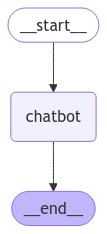

In [ ]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  # This requires some extra dependencies and is optional
  pass



In [ ]:
for event in graph.stream({"messages":[("user","I am Abdul Qadir")]}):
  print("EVENT: ",list(event.values())[0]["messages"][-1])

EVENT:  content="Hello Abdul Qadir, it's nice to meet you! \n\nIs there anything I can help you with today? I'm ready to answer questions, provide information, or just have a chat. \n" additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]} id='run-c7df6fd9-1d47-43fc-b86a-5ea0edfd8c7b-0' usage_metadata={'input_tokens': 6, 'output_tokens': 42, 'total_tokens': 48, 'input_token_details': {'cache_read': 0}}


In [ ]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
      print("Assistant", value["messages"][-1].content)

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit","exit","q"]:
      print("Good bye!")
      break
    stream_graph_updates(user_input)
  except:
    # fallback if input is not available
    user_input = "What do you know about LangGraph?"
    print("User: "+ user_input)
    stream_graph_updates(user_input)
    break

User: Hey
Assistant Hey there! What can I do for you today? 

User: I am Abdul Qadir.
Assistant Nice to meet you, Abdul Qadir! Is there anything I can help you with today? 

User: Can you tell me about unconcious mind.
Assistant ## The Unconscious Mind: A Deep Dive

The unconscious mind is a fascinating and complex concept that has captivated philosophers and psychologists for centuries. While we can't directly observe it, its influence on our thoughts, feelings, and actions is undeniable. 

Here's a breakdown of key aspects:

**What is the Unconscious Mind?**

* **The Hidden Realm:** It refers to the part of our mind that operates outside our conscious awareness. It's a vast reservoir of thoughts, feelings, memories, and impulses that we are not directly aware of.
* **Beyond Conscious Control:** We have little to no conscious control over this realm. It processes information and influences our behavior without our conscious knowledge.
* **A Powerful Influence:** Despite being hidden, 

**Congratulations!** You've built your first chatbot using LangGraph. This bot can engage in basic conversation by taking user input and generating responses using an LLM. You can inspect a [LangSmith Trace](https://smith.langchain.com/public/7527e308-9502-4894-b347-f34385740d5a/r) for the call above at the provided link.

However, you may have noticed that the bot's knowledge is limited to what's in its training data. In the next part, we'll add a web search tool to expand the bot's knowledge and make it more capable.

Below is the full code for this section for your reference:

<details>
<summary>Full Code</summary>
    <pre>
        
```python
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()
```

</pre>
</details>

## Part 2: Enhancing the Chatbot with Tools

To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.

#### Requirements

Before we start, make sure you have the necessary packages installed and API keys set up:

First, install the requirements to use the [Tavily Search Engine](https://python.langchain.com/docs/integrations/tools/tavily_search/), and set your [TAVILY_API_KEY](https://tavily.com/).

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python langchain_community

In [ ]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

# Next define the tools

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("Whats the weather in Lahore Today?")

[{'url': 'https://www.timeanddate.com/weather/pakistan/lahore/ext',
  'content': 'Lahore 14 Day Extended Forecast. Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 70 °F. Fog. (Weather station: Lahore Airport, Pakistan). See more current weather.'},
 {'url': 'https://www.accuweather.com/en/pk/lahore/260622/weather-today/260622',
  'content': "Everything you need to know about today's weather in Lahore, Punjab, Pakistan. High/Low, Precipitation Chances, Sunrise/Sunset, and today's Temperature History."}]

The results are page summaries our chat bot can use to answer questions.


Next, we'll start defining our graph. The following is all **the same as in Part 1**, except we have added `bind_tools` on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

def State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
  return {"messages": llm_with_tools.invoke((state["messages"]))}

graph_builder.add_node("chatbot",chatbot)

/usr/local/lib/python3.10/dist-packages/langgraph/graph/state.py:64: UserWarning: Invalid state_schema: <function State at 0x7d9047ab4af0>. Expected a type or Annotated[type, reducer]. Please provide a valid schema to ensure correct updates.
 See: https://langchain-ai.github.io/langgraph/reference/graphs/#stategraph
  warnings.warn(


Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) to speed things up, but building it ourselves first is instructive.

In [ ]:
tools_by_name = {tool.name: tool for tool in tools}
print(type(tools_by_name))
print(tools_by_name)

tools_by_name["tavily_search_results_json"]

llm_with_tools.invoke("Who won in the 2024 Presidential elections?")

<class 'dict'>
{'tavily_search_results_json': TavilySearchResults(max_results=2, api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))}


AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "2024 Presidential elections"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-d6ccf677-56ba-4352-bcdb-fc68e3ff7052-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '2024 Presidential elections'}, 'id': 'd98ad2b6-83a6-4bec-8c92-40d3ec75dcc2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 25, 'total_tokens': 111, 'input_token_details': {'cache_read': 0}})